In [1]:
!uv pip install jupyterlab-vim

Sourcing .zshenv...
Using Python 3.12.10 environment at: /home/flynn/repos/work/mbo_utilities/.venv
Audited 1 package in 8ms


In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
from pathlib import Path
import tifffile
import mbo_utilities as mbo

import tifffile
from tifffile.tifffile import read_scanimage_metadata

import fastplotlib as fpl
import matplotlib.pyplot as plt

import numpy as np
from scipy.ndimage import fourier_shift
from skimage.registration import phase_cross_correlation

def _subpix_offsets(frames, upsample, border):
    t, b, l, r = border
    offs = np.zeros(frames.shape[0], dtype=np.float32)
    row_sl = slice(t, -b or None)
    col_sl = slice(l, -r or None)

    for i, fr in enumerate(frames):
        even, odd = fr[::2], fr[1::2]
        m = min(even.shape[0], odd.shape[0])
        if even.ndim == 3:
            ec = even[:m, row_sl, col_sl]
            oc = odd[:m, row_sl, col_sl]
        else:
            ec = even[row_sl, col_sl]
            oc = odd[row_sl, col_sl]
        shift, *_ = phase_cross_correlation(ec, oc, upsample_factor=upsample)
        offs[i] = shift[1]
    return offs


def compute_scan_phase_offsets(arr, *, upsample=10, border=0):
    if isinstance(border, int):
        border = (border,) * 4
    y, x = arr.shape[-2:]
    flat = np.asarray(arr).reshape(-1, y, x)
    return _subpix_offsets(flat, upsample, border)


def apply_scan_phase_offsets(arr, offs):
    a = np.asarray(arr)
    y, x = a.shape[-2:]
    flat = a.reshape(-1, y, x).copy()
    if np.any(offs):
        rows = flat[:, 1::2]
        fft = np.fft.fftn(rows, axes=(1, 2))
        for k, off in enumerate(offs):
            fft[k] = fourier_shift(fft[k], (0, off))
        flat[:, 1::2] = np.fft.ifftn(fft, axes=(1, 2)).real
    return flat.reshape(a.shape)
# import dask.array as da

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
files = mbo.get_files("/home/flynn/lbm_data/raw",max_depth=3)
files                      

['/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00004.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00002.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00010.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00008.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00005.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00001.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00000.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00009.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00003.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00006.tif',
 '/home/flynn/lbm_data/raw/mk3

In [18]:
with tifffile.TiffFile(files[0], is_scanimage=False) as tif:
    data = tif.asarray()
    h, w = data.shape[1:]
    dtype = data.dtype

    bytes_per_frame = h * w * np.dtype(dtype).itemsize
    max_frames = (50 * 1024**2) // bytes_per_frame  # 50 MB
    sliced = data[:max_frames]
    
print(sliced.shape)

(128, 912, 224)


In [19]:
with open(files[0], 'rb') as f:
    frame_data, roi_data, version = read_scanimage_metadata(f)

    frame_bytes = sliced.shape[1] * sliced.shape[2] * np.dtype(sliced.dtype).itemsize
    max_frames = int((50 * 1024**2) // frame_bytes)
    sliced = full_data[:max_frames]

In [30]:
from tifffile import TiffWriter
import struct
import json

save_path = Path().cwd().parent.joinpath("data")
save_file = save_path.joinpath("demo.tif")

In [51]:
def matlabstr(obj):
    """Convert Python dict to ScanImage-style MATLAB string."""
    def _format(v):
        if isinstance(v, list):
            if all(isinstance(i, str) for i in v):
                return '{' + ' '.join(f"'{i}'" for i in v) + '}'
            return '[' + ' '.join(str(i) for i in v) + ']'
        if isinstance(v, str):
            return f"'{v}'"
        if isinstance(v, bool):
            return 'true' if v else 'false'
        return str(v)

    return '\n'.join(f"{k} = {_format(v)}" for k, v in obj.items())


In [37]:
sp = r"C:\Users\RBO\repos\mbo_utilities\data"
with open(save_file, 'wb') as f:
    # Write ScanImage header manually
    f.write(struct.pack('<2sH', b'II', 43))  # BigTIFF header
    f.seek(16)

    # Fake ScanImage metadata block (exactly like original)
    metadata_bin = bytearray()
    metadata_bin += struct.pack('<IIII', 117637889, version, 0, 0)  # placeholder sizes

    # Serialize static + ROI metadata
    # static_txt = tifffile.matlabstr2py(frame_data).encode('utf-8') + b'\0'
    static_txt = matlabstr(frame_data).encode('utf-8') + b'\0'

    roi_txt = json.dumps(roi_data, separators=(',', ':')).encode('utf-8')

    size0 = len(static_txt)
    size1 = len(roi_txt)
    metadata_bin[8:16] = struct.pack('<II', size0, size1)
    metadata_bin += static_txt
    metadata_bin += roi_txt

    # Write metadata
    f.write(metadata_bin)

    offset_to_first_ifd = f.tell()

In [39]:
type(f)

_io.BufferedWriter

In [55]:
import tifffile
import numpy as np
import shutil

def trim_tiff_frames(input_path, output_path, max_frames=20):
    # Copy original file to preserve metadata
    shutil.copyfile(input_path, output_path)

    with tifffile.TiffFile(input_path, is_scanimage=False) as tif:
        data = tif.asarray()[:max_frames]

    with tifffile.TiffWriter(output_path, bigtiff=True, append=True) as tif_writer:
        for frame in data:
            tif_writer.write(
                frame,
                contiguous=False,
                metadata=None,
                software=None,
                description=None
            )


In [57]:
trim_tiff_frames(
    input_path=files[0],
    output_path=r"..\data\scanimage_trimmed.tif",
    max_frames=50
)

In [58]:
output_path= r"..\data\scanimage_trimmed.tif"
new = tifffile.imread(output_path)

<tifffile.TiffFile 'scanimage_trimmed.tif'> ScanImage series raised ValueError('unable to determine framesPerSlice')


In [11]:
files = mbo.get_files(fname, 'tif', 1)
files

['D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00000.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00001.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00002.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00003.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00004.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00005.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00006.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00007.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk30

In [16]:
data = tifffile.memmap(files[6])

In [22]:
fig = fpl.Figure()
volume = fig[0,0].add_image_volume(data=data[:500])

# volume.interpolation = "linear"
volume.cmap = "gnuplot2"

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
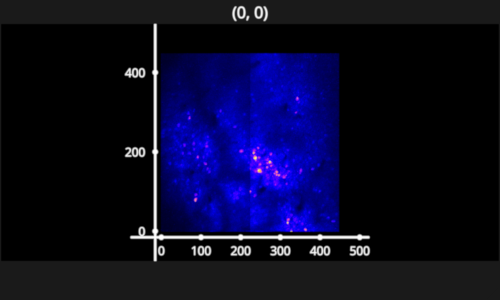

In [23]:
fig.show()

In [9]:
fname_scan = r"D:\W2_DATA\kbarber\2025_03_01\mk301\green\*"
raw_scan = mbo.read_scan(fname_scan)

Detected possible escaped characters in the path. Use a raw string (r'...') or double backslashes.


In [52]:
mbo.save_as(raw_scan, r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled_zarr", planes=[0, 7, 13], ext=".zarr")

Reading tiff series data...
Reading tiff pages...
Raw tiff fully read.


Saving plane 1:   0%|          | 0/216 [00:00<?, ?it/s]

num-chunks: 216


Saving plane 8:   0%|          | 0/216 [00:00<?, ?it/s]

num-chunks: 216


Saving plane 14:   0%|          | 0/216 [00:00<?, ?it/s]

num-chunks: 216
Time elapsed: 0 minutes 33 seconds.


In [55]:
zpath = r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled_zarr"
arr = mbo.zarr_to_dask(zpath)

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
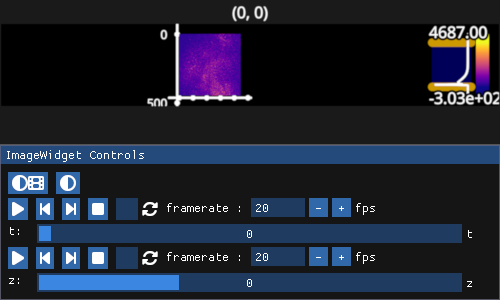

In [56]:
iw = fpl.ImageWidget(arr)
iw.show()

In [23]:
iw = mbo.run_gui(data)

Data provided and set.
Is running jupyter
Running jupyter, data provided. Making ImageWidget


ValueError: Found no accessible jobs in dask

In [4]:
iw.close()

NameError: name 'files' is not defined